## Loading Data, Data Augmentation

In [229]:
import torch
from torchvision import datasets, transforms

data_dir = 'Cat_Dog_Dataset'

# Load Data
transform_test = transforms.Compose([transforms.Resize(255),
                                   transforms.CenterCrop(224), 
                               transforms.ToTensor()])

transform_train = transforms.Compose([ transforms.RandomRotation(30),
                                        transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train/..', transform=transform_train)
test_data = datasets.ImageFolder(data_dir + '/test1/..', transform=transform_test)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [230]:
datatrainiter = iter(trainloader)
datatestiter = iter(testloader)

## Visualize Data We Dealing With

In [231]:
#Inspecting Train Data
images, labels = next(datatestiter)

print(images.shape)

print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [232]:
labels

tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1])

In [233]:
x = labels.numpy()

index_zero = np.where(x==0)
index_one = np.where(x==1)

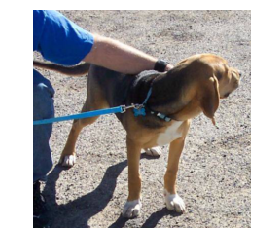

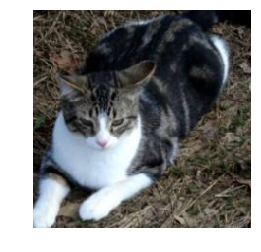

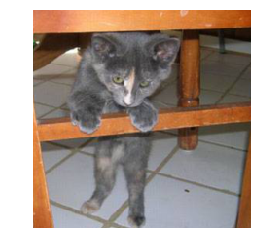

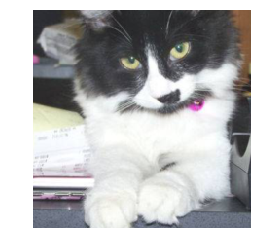

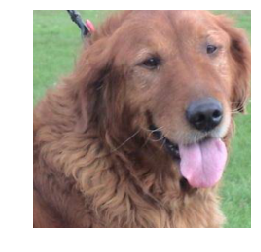

In [196]:
import numpy as np
import matplotlib.pyplot as plt

for i in index_zero[0] :
    images_roll = np.rollaxis(images[i].numpy(), 0, 3)
    plt.imshow(images_roll)
    plt.axis('off')
    plt.show()

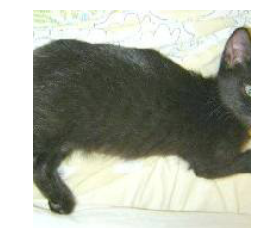

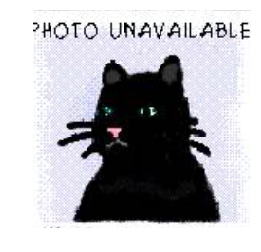

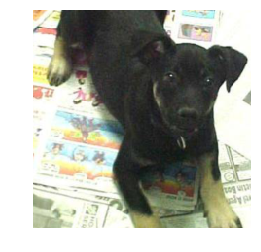

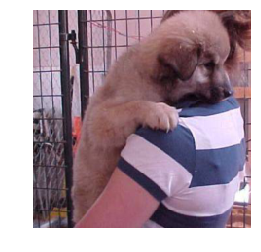

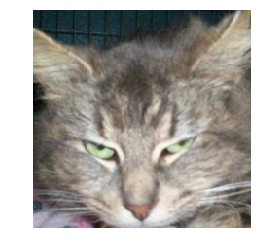

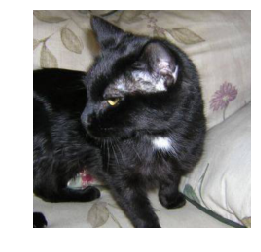

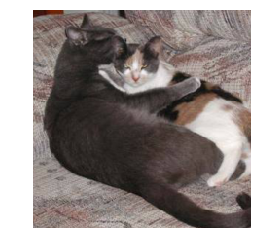

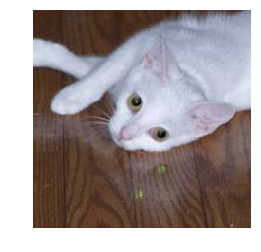

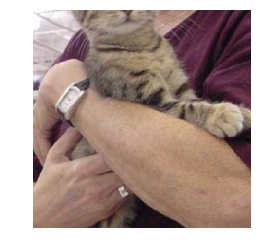

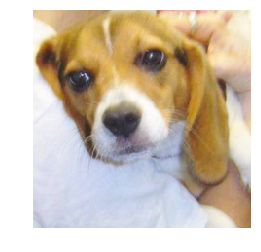

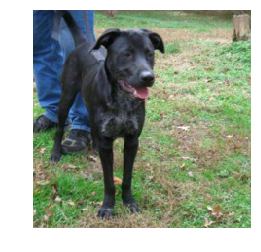

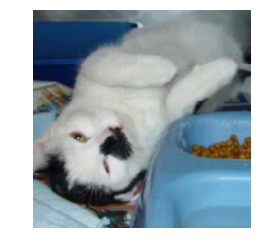

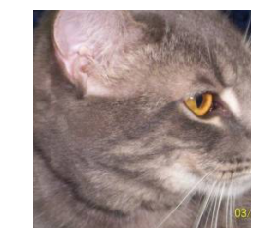

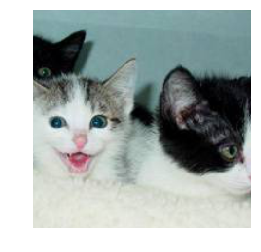

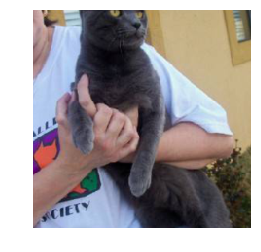

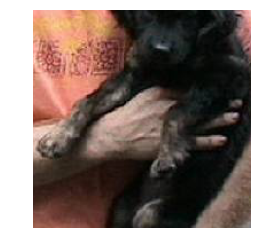

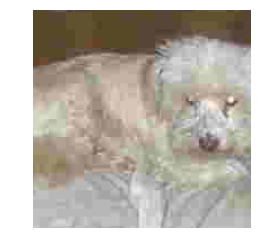

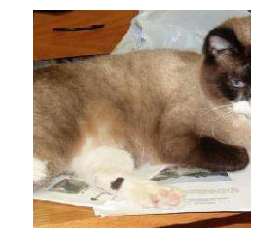

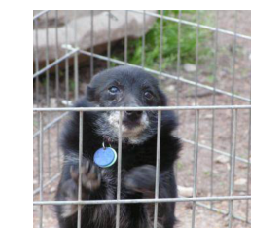

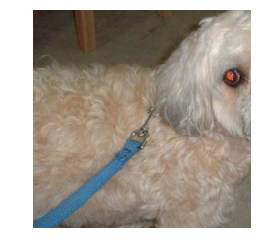

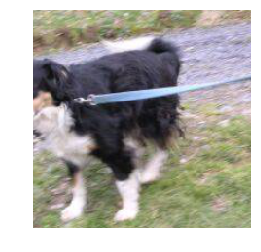

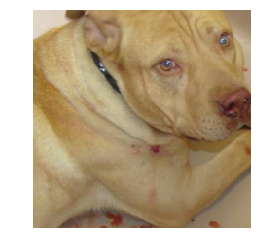

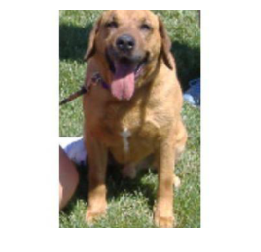

In [90]:
import numpy as np
import matplotlib.pyplot as plt
for i in index_one[0] :
    images_roll = np.rollaxis(images[i].numpy(), 0, 3)
    plt.imshow(images_roll)
    plt.axis('off')
    plt.show()

## Transfer Learning

Load Pretrained Model such DenseNet

In [323]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [324]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [329]:
# freeze feature parameters
for param in model.parameters() :
    param.requires_grad = False
    
# Define New Classifier
classifier = nn.Sequential(nn.Linear(2048, 218),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(218, 2),
                          nn.LogSoftmax(dim=1))

model.fc = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [330]:
epochs = 1
steps=0
running_loss = 0
print_every = 3

for epoch in range(epochs) :
    
    for images, labels in trainloader :
        
        steps +=1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        print(loss)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0 :
            model.eval()
            test_loss =0
            accuracy = 0
            
            for i in range(4) :
                print('test')
                
                images, labels = next(iter(testloader))
                
                images, labels = images.to(device), labels.to(device)
                
                output = model(images)
                loss = criterion(output, labels)
                print(loss)
                test_loss += loss
                
                # Calculate Accuracy
                ps = torch.exp(output)
                top_p, top_k = ps.topk(1, dim=1)
                equals = top_k == labels.view(*top_k.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            print('Epoch : {}..'.format(epoch+1/epochs))
            print('Train Loss : {}..'.format(running_loss/print_every))
            print('Test Loss : {}..'.format(test_loss/4))
            print('Accuracy : {}..'.format(accuracy/4))
            
            
            running_loss = 0
            model.train()
                  

tensor(0.7212, grad_fn=<NllLossBackward>)
tensor(2.4193, grad_fn=<NllLossBackward>)
tensor(1.5322, grad_fn=<NllLossBackward>)
test
tensor(0.6258, grad_fn=<NllLossBackward>)
test
tensor(0.6122, grad_fn=<NllLossBackward>)
test
tensor(0.6558, grad_fn=<NllLossBackward>)
test
tensor(0.6313, grad_fn=<NllLossBackward>)
Epoch : 1.0..
Train Loss : 1.5575665831565857..
Test Loss : 0.6312702894210815..
Accuracy : 0.6640625..
tensor(0.6953, grad_fn=<NllLossBackward>)
tensor(0.5871, grad_fn=<NllLossBackward>)
tensor(1.0503, grad_fn=<NllLossBackward>)
test
tensor(0.6409, grad_fn=<NllLossBackward>)
test
tensor(0.8642, grad_fn=<NllLossBackward>)
test
tensor(0.7493, grad_fn=<NllLossBackward>)
test
tensor(0.6929, grad_fn=<NllLossBackward>)
Epoch : 1.0..
Train Loss : 0.7775931358337402..
Test Loss : 0.7368189692497253..
Accuracy : 0.640625..
tensor(0.5152, grad_fn=<NllLossBackward>)
tensor(0.6600, grad_fn=<NllLossBackward>)
tensor(0.7636, grad_fn=<NllLossBackward>)
test
tensor(0.7413, grad_fn=<NllLossBac

KeyboardInterrupt: 